# **Notes on: Strawberry Fields API**

**Useful links**
- [Quick Guide: Circuits](https://strawberryfields.readthedocs.io/en/stable/introduction/circuits.html)
- [Quick Guide: Operations](https://strawberryfields.readthedocs.io/en/stable/introduction/ops.html)
- [Quick Guide: States](https://strawberryfields.readthedocs.io/en/stable/introduction/states.html)
- [Tutorial: CV quantum gate visualizations](https://strawberryfields.ai/photonics/demos/run_gate_visualization.html)
- [Gates](https://strawberryfields.ai/photonics/conventions/gates.html)

## Code and Implementation

### Working Through Tutorial: Quantum Gate Visualizations

#### **Imports:**

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### **Useful Functions**

In [3]:
def plot_wigner(state, title = "Wigner Function of State"):
    fig = plt.figure()
    x = np.linspace(-5, 5, 100)
    p = np.linspace(-5, 5, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()
        

#### **Vacuum State**

In [4]:
prog = sf.Program(1) # intialize the program with 1 qumode

with prog.context as q:
    Vac | q[0] # prepare the vacuum state (note! the default state in SF is the vacuum state)

eng = sf.Engine('gaussian') # using the Gaussian backend (as opposed to fock, or tf backends)
state = eng.run(prog).state


Visualize the state

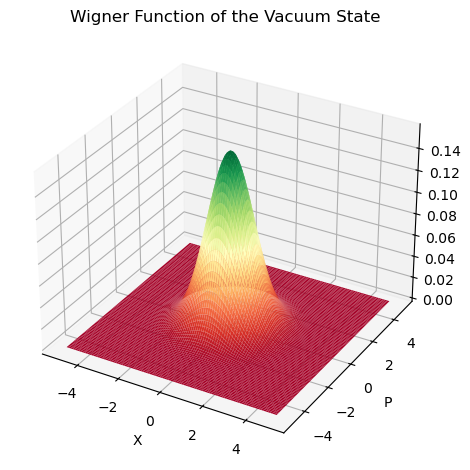

In [5]:
plot_wigner(state, title = "Wigner Function of the Vacuum State")


#### **Squeezing Gate and Squeezed State**
[SGate Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Sgate.html#strawberryfields.ops.Sgate)
- `r` - squeezing amount
- `phi` - squeezing phase angle $\phi$

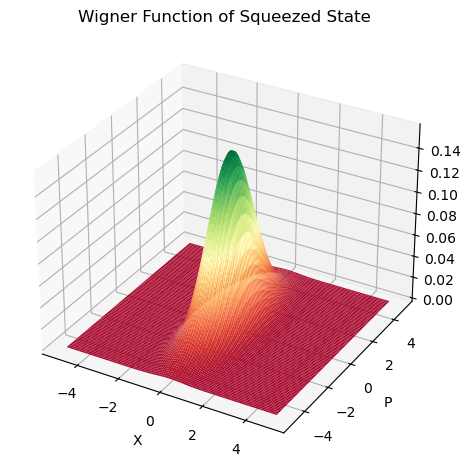

In [6]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    S = Sgate(0.5) # define the S gate with a squeezing parameter of 0.2
    S | q[0] # apply the S gate to the qumode
    
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Squeezed State")

#### **Fock State**

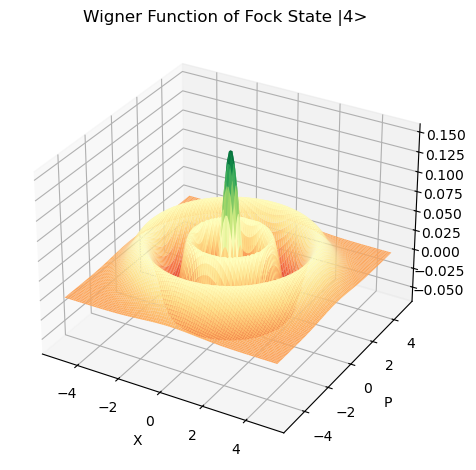

In [15]:
prog = sf.Program(1)
with prog.context as q:
    Fock(4) | q[0] # prepare the Fock state |1>

eng = sf.Engine('fock', backend_options={"cutoff_dim": 10}) # use the fock backend with a cutoff dimension of 10
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Fock State |4>")


#### **Displacement Gate and Coherent States**
[DGate Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Dgate.html#strawberryfields.ops.Dgate)

The displacement gate has a specified complex value $ \alpha $. It shifts $ \hat{x} $ by a value proportional to $ \text{Re}(\alpha) $ and $ \hat{p} $ by a value proportional to $ \text{Im}(\alpha) $.
- `r` - displacement magnitude $|\alpha|$
- `phi` - displacement angle $\phi$


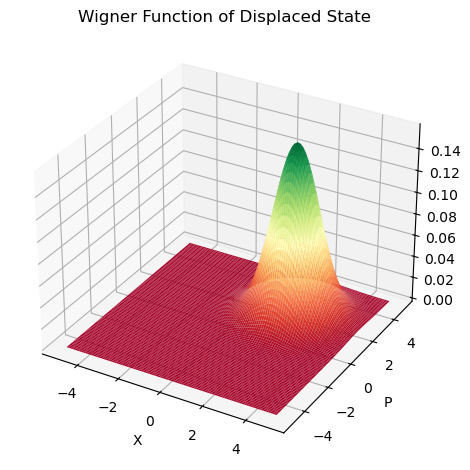

In [26]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    Dgate(np.sqrt(2), np.pi / 4) | q[0]
    
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Displaced State")

#### **Rotation Gate**
Gate rotates phase space. 

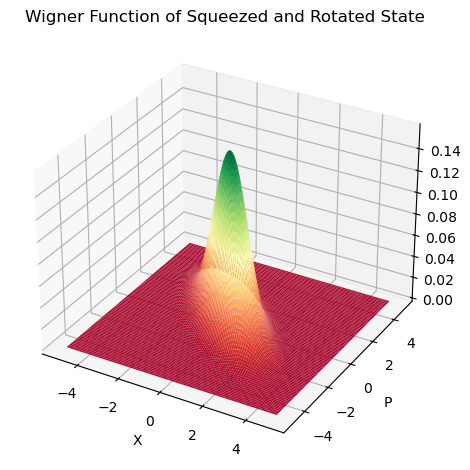

In [19]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    S = Sgate(0.5) # define the S gate with a squeezing parameter of 0.2
    S | q[0] # apply the S gate to the qumode
    Rgate(np.pi/4) | q[0]
    
eng.reset()
state = eng.run(prog).state
plot_wigner(state, title = "Wigner Function of Squeezed and Rotated State")

#### **Cubic Phase Gate (Non-Gaussian)**

[VGate Documentation](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Vgate.html#strawberryfields.ops.Vgate)


The cubic phase gate shifts $ \hat{p} $ by $ \gamma \hat{x}^2 $, where $ \gamma $ is a definable parameter but does not transform $ \hat{x} $ in the phase space. 

$$V(\gamma) = e^{i \frac{\gamma}{3 \hbar} \hat{x}^3}$$

$$ V^\dagger(\gamma) \hat{x} V(\gamma) = \hat{x} $$
$$ V^\dagger(\gamma) \hat{p} V(\gamma) = \hat{p} +\gamma \hat{x}^2 $$

When running a circuit that contains any non-Gaussian gates, we use the Fock backend. Depending on the backend used, different arguments will have to be called. In this example, we define `cutoff_dim`, which tells Strawberry Fields where to limit the Fock space.


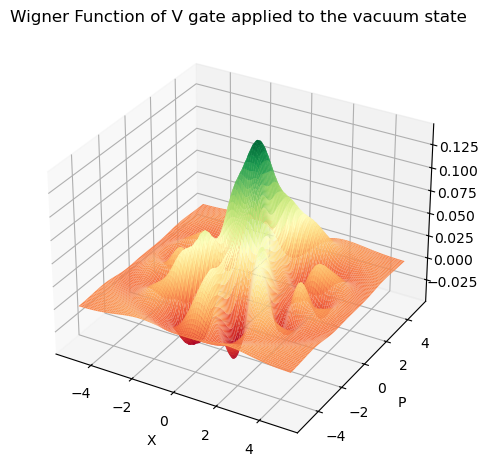

In [32]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    gamma = 2
    Vgate(gamma) | q[0]

#We use the fock backend and define the argument cutoff_dim
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10}) # cutoff_dim is the number of Fock states to truncate to (highest Fock state will be cutoff_dim - 1)
state = eng.run(prog).state

plot_wigner(state, title = "Wigner Function of V gate applied to the vacuum state")

#### **Kerr Gate (Non-Gaussian)**
[KGate Documentation](https://strawberryfields.ai/photonics/demos/run_gate_visualization.html#kerr-gate)

In the Fock basis, the rotation gate acts with $ e^{i\phi\hat{n}} $. In comparison, **the Kerr gate transforms** with $ e^{i\phi_k\hat{n}^2} $. The $ \hat{n}^2 $ term is what makes this state non-Gaussian, thereby transforming the shape of the state significantly.

$$K(\kappa) = e^{i \kappa \hat{n}^2}$$

- `kappa` - $\kappa$ parameter

The Kerr interaction is given by the Hamiltonian  

$$ H = (\hat{a}^\dagger \hat{a})^2 = \hat{n}^2 $$  

which is non-Gaussian and diagonal in the Fock basis.  




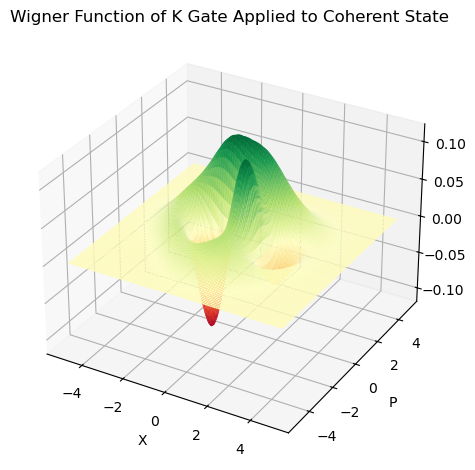

In [38]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state
    kappa = 1 # set the value of the kappa parameter
    Dgate(1) | q[0] # apply the displacement gate
    Kgate(kappa) | q[0]

eng.reset()
state = eng.run(prog).state

plot_wigner(state, title = "Wigner Function of K Gate Applied to Coherent State")

## **Theory**

#### **Gaussian vs Non-Gaussian States and Gates**

*States*
- `Gaussian States` are states with zero-valued Wigner Negativity whose Wigner Functions are Gaussian-shaped (completely determined by its first two moments). Examples are
    - Coherent States
    - Squeezed States (non-rotationally-symmetric)
- `Non-Gaussian States` are states which can reach negative regions of phase space (i.e. Wigner Negativity can take negative values for some quadrature values). Their Wigner Functions are not Gaussian-shaped (cannot be fully described by their first two moments, exhibit nontrivial features such as negativity or oscillatory patterns)
    - Fock States

*Gates*
- `Gaussian Gates` act linearly on modes. These gates can only reach positive quasi-probability distributions and can be classically simulated
    - Squeezing Gate
    - Rotation Gate
    - Displacement Gate
- `Non-Gaussian Gates` act nonlinearly. This property allows them to be in negative quasi-probability distributions and not be classically simulated.
    - Kerr Gate
    - Cubic Phase Gate





#### **What is a Qumode?**

A **qumode** (quantum mode) is a fundamental concept in continuous-variable (CV) quantum computing. It represents a quantum optical mode, analogous to a qubit in standard quantum computing, but specifically for systems that encode quantum information in continuous variables like the quadratures of the electromagnetic field.

#### Key Characteristics of Qumodes

1. **Continuous Variables (CV):**
   Qumodes encode quantum information in continuous properties, such as position (\( \hat{x} \)) and momentum (\( \hat{p} \)) quadratures of light.

2. **State Representation:**
   A qumode's quantum state can be expressed in the Fock basis (number states) or using the Wigner function in phase space. Examples include:
   - Squeezed states
   - Coherent states
   - Thermal states

3. **Operations:**
   Operations on qumodes include:
   - Gaussian transformations: squeezing, displacement, rotation
   - Non-Gaussian transformations: photon addition, photon subtraction

4. **Comparison to Qubits:**
   - While qubits use discrete binary states (∣0⟩, ∣1⟩), qumodes leverage continuous states, enabling different computational paradigms suited for specific types of problems.